In [1]:
import os

from ultralytics import YOLO
from ultralytics.data import utils
from ultralytics.utils.ops import resample_segments
from ultralytics.data import YOLODataset
from ultralytics.utils.instance import Instances
from PIL import Image
import torch
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
%matplotlib inline

In [3]:
def my_polygon2mask(imgsz, polygons, color=1, downsample_ratio=1):
    mask = np.zeros(imgsz, dtype=np.uint8)
    polygons = np.asarray(polygons, dtype=np.int32)
    polygons = polygons.reshape((polygons.shape[0], -1, 2))

    # cv2.fillPoly(mask, polygons, color=color)
    cv2.drawContours(mask, polygons, -1, color, 5)

    nh, nw = (imgsz[0] // downsample_ratio, imgsz[1] // downsample_ratio)
    return cv2.resize(mask, (nw, nh))

In [4]:
utils.polygon2mask = my_polygon2mask

In [5]:
def my_update_labels_info(self, label):
    bboxes = label.pop("bboxes")
    segments = label.pop("segments", [])
    keypoints = label.pop("keypoints", None)
    bbox_format = label.pop("bbox_format")
    normalized = label.pop("normalized")

    segment_resamples = 100 if self.use_obb else 58338
    if len(segments) > 0:
        segments = np.stack(resample_segments(segments, n=segment_resamples), axis=0)
    else:
        segments = np.zeros((0, segment_resamples, 2), dtype=np.float32)

    label["instances"] = Instances(bboxes, segments, keypoints, bbox_format=bbox_format, normalized=normalized)
    return label

In [6]:
YOLODataset.update_labels_info = my_update_labels_info

In [7]:
class RoadThicknessTransform:
    def __init__(self, min_thickness, max_thickness):
        self.min_thickness = min_thickness
        self.max_thickness = max_thickness

    def __call__(self, labels):
        masks = labels['masks']
        if len(masks) != 0:
            random_thickness = np.random.randint(self.min_thickness, self.max_thickness)
            kernel = np.ones((random_thickness, random_thickness), np.uint8)
    
            new_mask_all = np.zeros_like(masks[0])
            new_masks = []
    
            for mask in masks:
                mask = mask.cpu().numpy()
                new_mask = cv2.dilate(mask, kernel, iterations=1)
                new_mask_all = np.logical_or(new_mask_all, new_mask)
                new_masks.append(new_mask)
    
            new_masks = torch.Tensor(np.array(new_masks))
    
            image = labels['img'].permute(1, 2, 0).cpu().numpy()
            image_expanded = cv2.dilate(image, kernel, iterations=1)
            new_image = image
            new_image[new_mask_all == 255] = image_expanded[new_mask_all == 255]
    
            labels['masks'] = new_masks
            labels['img'] = torch.Tensor(new_image).permute(2, 0, 1)

        return labels

In [8]:
def add_custom_augmentation(trainer):
    trainer.train_loader.dataset.transforms.append(RoadThicknessTransform(3, 10))

In [9]:
model = YOLO('yolov8n-seg.pt')
model.add_callback('on_pretrain_routine_end', add_custom_augmentation)

In [ ]:
# model.train(data='datasets/data.yaml', time=4, batch=8, imgsz=1024, cls=0, dfl=0, verbose=True, plots=True, hsv_h=0.02, hsv_s=0.75, hsv_v=0.5, degrees=60, translate=0.2, scale=0.5, shear=60, perspective=0.0005, flipud=0.5, fliplr=0.5, mosaic=1, mixup=0.5, copy_paste=0.2, auto_augment='randaugment', erasing=0, crop_fraction=0)
model.train(data='datasets/data.yaml', time=12, batch=8, imgsz=1280, mask_ratio=1, overlap_mask=False, degrees=60, shear=15, flipud=0.5, verbose=True, plots=True, workers=0)

New https://pypi.org/project/ultralytics/8.2.11 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.11 🚀 Python-3.11.9 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=datasets/data.yaml, epochs=100, time=12, patience=50, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train51, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=False, mask_ratio=1, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fal

train: Scanning C:\Users\User\Documents\MyProjects\AI\task3\datasets\MassachusettsRoads\tiff\labels\train.cache... 1107 images, 13 backgrounds, 0 corrupt: 100%|██████████| 1108/1108 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\User\Documents\MyProjects\AI\task3\datasets\MassachusettsRoads\tiff\labels\val.cache... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<?, ?it/s]


Plotting labels to runs\segment\train51\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 0 dataloader workers
Logging results to runs\segment\train51
Starting training for 12 hours...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.41G      2.396      3.143      3.593      2.391         33       1280: 100%|██████████| 139/139 [07:17<00:00,  3.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]

                   all         14        128      0.099      0.102     0.0505      0.028      0.121     0.0391      0.026    0.00445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/98      6.56G      2.097      2.358      2.898      2.135         38       1280: 100%|██████████| 139/139 [07:13<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

                   all         14        128      0.168      0.195     0.0809     0.0254     0.0696     0.0703      0.014    0.00225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/99      6.19G      2.064      2.337      2.684      2.124         32       1280: 100%|██████████| 139/139 [07:16<00:00,  3.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

                   all         14        128      0.112      0.242     0.0797     0.0276     0.0547      0.117     0.0255    0.00339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/99      5.78G      1.984      2.294      2.498      2.048         45       1280: 100%|██████████| 139/139 [07:19<00:00,  3.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

                   all         14        128       0.23      0.242     0.0969     0.0399      0.117      0.125     0.0282    0.00437



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/99      5.84G      1.943      2.189      2.388      2.018         40       1280: 100%|██████████| 139/139 [07:12<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

                   all         14        128      0.277      0.289       0.18     0.0693      0.121     0.0938     0.0587    0.00785



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/99      5.82G        1.9      2.198       2.33      2.008         56       1280: 100%|██████████| 139/139 [07:25<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

                   all         14        128       0.21       0.25      0.133     0.0423     0.0993      0.133     0.0358    0.00531



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/99      5.87G      1.847      2.099      2.237      1.927         31       1280: 100%|██████████| 139/139 [07:11<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all         14        128      0.216      0.273      0.125     0.0535      0.127       0.14     0.0432    0.00712



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/99      5.79G      1.834      2.119      2.202      1.927         26       1280: 100%|██████████| 139/139 [07:21<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all         14        128       0.18      0.312      0.126     0.0383     0.0732      0.133     0.0314    0.00532



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/99      6.72G      1.805      2.112      2.162      1.916         26       1280: 100%|██████████| 139/139 [07:36<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

                   all         14        128      0.249      0.281      0.131     0.0403      0.125      0.141     0.0319    0.00462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/98      5.98G      1.769      2.106       2.08      1.866         41       1280: 100%|██████████| 139/139 [07:21<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

                   all         14        128       0.26      0.305      0.142     0.0473      0.112      0.156     0.0315    0.00525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/98      5.97G      1.741      2.027      2.055      1.865         29       1280: 100%|██████████| 139/139 [07:15<00:00,  3.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all         14        128      0.208      0.297      0.139     0.0466       0.14      0.133     0.0391    0.00662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/98      5.82G      1.744      2.047      2.022      1.844         49       1280: 100%|██████████| 139/139 [07:16<00:00,  3.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all         14        128      0.297      0.289      0.154     0.0527      0.136      0.133     0.0364    0.00593



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/98      5.76G       1.69      2.005      1.988      1.814         53       1280: 100%|██████████| 139/139 [07:11<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

                   all         14        128      0.317      0.281       0.17     0.0673      0.186      0.156      0.057    0.00893



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/99      5.87G      1.687      1.942      1.939      1.806         34       1280: 100%|██████████| 139/139 [07:20<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

                   all         14        128      0.386      0.266      0.213      0.082      0.156      0.148      0.059     0.0103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/98      5.72G       1.66      1.967      1.938      1.795         33       1280: 100%|██████████| 139/139 [07:05<00:00,  3.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

                   all         14        128      0.331      0.352       0.24     0.0838      0.134      0.133     0.0436    0.00736



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/99      6.93G      1.652       1.99      1.928      1.786         27       1280: 100%|██████████| 139/139 [07:06<00:00,  3.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

                   all         14        128      0.313      0.359      0.177     0.0633       0.11      0.156     0.0303     0.0046



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/99      6.13G      1.649      2.006      1.901      1.762         59       1280: 100%|██████████| 139/139 [07:27<00:00,  3.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

                   all         14        128      0.459      0.304      0.257      0.092      0.235      0.156     0.0647     0.0102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/99      5.92G      1.638      1.971      1.875      1.771         65       1280: 100%|██████████| 139/139 [07:18<00:00,  3.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

                   all         14        128      0.273      0.344      0.214     0.0753      0.178      0.125     0.0576     0.0109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/99      6.16G      1.617      1.958      1.879       1.75         48       1280: 100%|██████████| 139/139 [07:28<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all         14        128      0.368      0.328      0.241     0.0852      0.161      0.148     0.0436    0.00704



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/99      6.18G      1.597      1.906      1.843      1.738         33       1280: 100%|██████████| 139/139 [07:18<00:00,  3.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

                   all         14        128      0.343      0.328      0.233     0.0911      0.157      0.172     0.0583     0.0111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/99      5.88G      1.578      1.944      1.823       1.72         37       1280: 100%|██████████| 139/139 [07:25<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

                   all         14        128      0.312      0.375      0.224     0.0835      0.151      0.172     0.0582    0.00893



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/98      5.87G      1.573      1.917        1.8      1.714         17       1280: 100%|██████████| 139/139 [07:23<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all         14        128      0.347      0.422      0.292     0.0952      0.188      0.211     0.0728     0.0145



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/98      6.13G      1.567      1.909      1.821      1.704         22       1280: 100%|██████████| 139/139 [07:24<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

                   all         14        128      0.328      0.352      0.216     0.0763      0.177       0.18     0.0479    0.00795



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/98      6.06G      1.544      1.878      1.793      1.702         22       1280: 100%|██████████| 139/139 [07:13<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

                   all         14        128      0.329      0.367      0.219     0.0776      0.182      0.172     0.0581    0.00926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/98      5.72G      1.551      1.858      1.787      1.689         38       1280: 100%|██████████| 139/139 [07:22<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

                   all         14        128      0.323      0.398      0.241     0.0849      0.196       0.18     0.0628     0.0113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/98      5.84G      1.554      1.893      1.781      1.692         40       1280: 100%|██████████| 139/139 [07:21<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all         14        128      0.352      0.383      0.258     0.0854      0.194      0.195     0.0579    0.00965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/98      6.11G      1.516      1.823      1.727      1.674         21       1280: 100%|██████████| 139/139 [07:18<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all         14        128      0.403      0.312      0.231     0.0848      0.229       0.18     0.0685     0.0122



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/98      6.03G      1.513      1.841       1.73      1.682         26       1280: 100%|██████████| 139/139 [07:19<00:00,  3.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

                   all         14        128      0.358      0.331      0.269     0.0965      0.208      0.203     0.0805     0.0148



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/98      6.06G      1.506      1.885      1.737      1.664         33       1280: 100%|██████████| 139/139 [07:25<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

                   all         14        128       0.41      0.344      0.274     0.0969      0.248      0.164     0.0728     0.0135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/98      5.92G      1.495      1.839      1.693      1.653         30       1280: 100%|██████████| 139/139 [07:22<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

                   all         14        128      0.384      0.375      0.254     0.0927      0.181      0.211     0.0672     0.0108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/98      6.21G      1.508      1.845      1.727       1.66         37       1280: 100%|██████████| 139/139 [07:12<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

                   all         14        128      0.524       0.32      0.293        0.1      0.181      0.164     0.0593    0.00964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/98       5.8G      1.458      1.848      1.718      1.634         60       1280:  35%|███▌      | 49/139 [02:42<04:54,  3.27s/it]

In [11]:
model = YOLO('best.pt')
model.val(split='test', name='test7')

Ultralytics YOLOv8.1.31 🚀 Python-3.11.5 torch-2.2.2 CPU (Intel Core(TM) i7-8750H 2.20GHz)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /Users/terminator/Documents/PycharmProjects/AI/task3/datasets/MassachusettsRoads/tiff/labels/test... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<00:00, 63.24it/s]

val: New cache created: /Users/terminator/Documents/PycharmProjects/AI/task3/datasets/MassachusettsRoads/tiff/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:41<00:00, 10.36s/it]


                   all         49        332      0.533      0.452      0.447      0.191      0.328      0.283      0.173     0.0352
Speed: 7.9ms preprocess, 499.8ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/segment/test7


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x142282090>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    

In [12]:
def get_images_and_binary_masks(dataset_path, batch_size):
    test_images_dir = f'{dataset_path}/images/test'
    test_binary_masks_dir = f'{dataset_path}/binary_masks/test'
    
    images = []
    binary_masks = []
    
    transform = v2.Compose([v2.ToImage(), v2.Resize(640), v2.ToDtype(torch.float32, scale=True)])

    for image_name in os.listdir(test_images_dir)[:batch_size]:
        image = transform(Image.open(f'{test_images_dir}/{image_name}'))
        binary_mask = transform(Image.open(f'{test_binary_masks_dir}/{image_name[:-1]}'))
        
        images.append(image)
        binary_masks.append(binary_mask)
    
    images = torch.stack(images, dim=0)
    binary_masks = torch.stack(binary_masks, dim=0)
    
    return images, binary_masks

In [13]:
images, binary_masks = get_images_and_binary_masks('datasets/MassachusettsRoads/tiff', 16)

In [14]:
results = model(images)


0: 640x640 1 road, 122.3ms
1: 640x640 1 road, 122.3ms
2: 640x640 1 road, 122.3ms
3: 640x640 1 road, 122.3ms
4: 640x640 1 road, 122.3ms
5: 640x640 2 roads, 122.3ms
6: 640x640 1 road, 122.3ms
7: 640x640 1 road, 122.3ms
8: 640x640 1 road, 122.3ms
9: 640x640 1 road, 122.3ms
10: 640x640 1 road, 122.3ms
11: 640x640 2 roads, 122.3ms
12: 640x640 1 road, 122.3ms
13: 640x640 1 road, 122.3ms
14: 640x640 1 road, 122.3ms
15: 640x640 2 roads, 122.3ms
Speed: 0.0ms preprocess, 122.3ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)


In [15]:
def show_results(images, labels, predictions):
    print('\t\t\t\t\tIMAGE\t\t\t\t\tLABEL\t\t\t\t\tPREDICTION')
    plt.figure(figsize=(10, 30))
    
    len_predictions = len(predictions)
    
    images_np = images.cpu().detach().permute(0, 2, 3, 1).numpy()
    labels_np = labels.cpu().detach().permute(0, 2, 3, 1).numpy()
    
    for i in range(len_predictions):
        predicted_masks = results[i].masks
        predicted_mask = predicted_masks[0].data
        for j in range(predicted_masks.shape[0] - 1):
            predicted_mask = torch.logical_or(predicted_mask, predicted_masks[j + 1].data)
        predicted_mask_np = predicted_mask.cpu().detach().permute(1, 2, 0).numpy().astype(float)
        
        plt.subplot(len_predictions, 3, 3 * i + 1)
        plt.imshow(images_np[i])
        
        plt.subplot(len_predictions, 3, 3 * i + 2)
        plt.imshow(labels_np[i], cmap='gray')
        
        plt.subplot(len_predictions, 3, 3 * i + 3)
        plt.imshow(predicted_mask_np, cmap='gray')
        
    plt.show()

					IMAGE					LABEL					PREDICTION


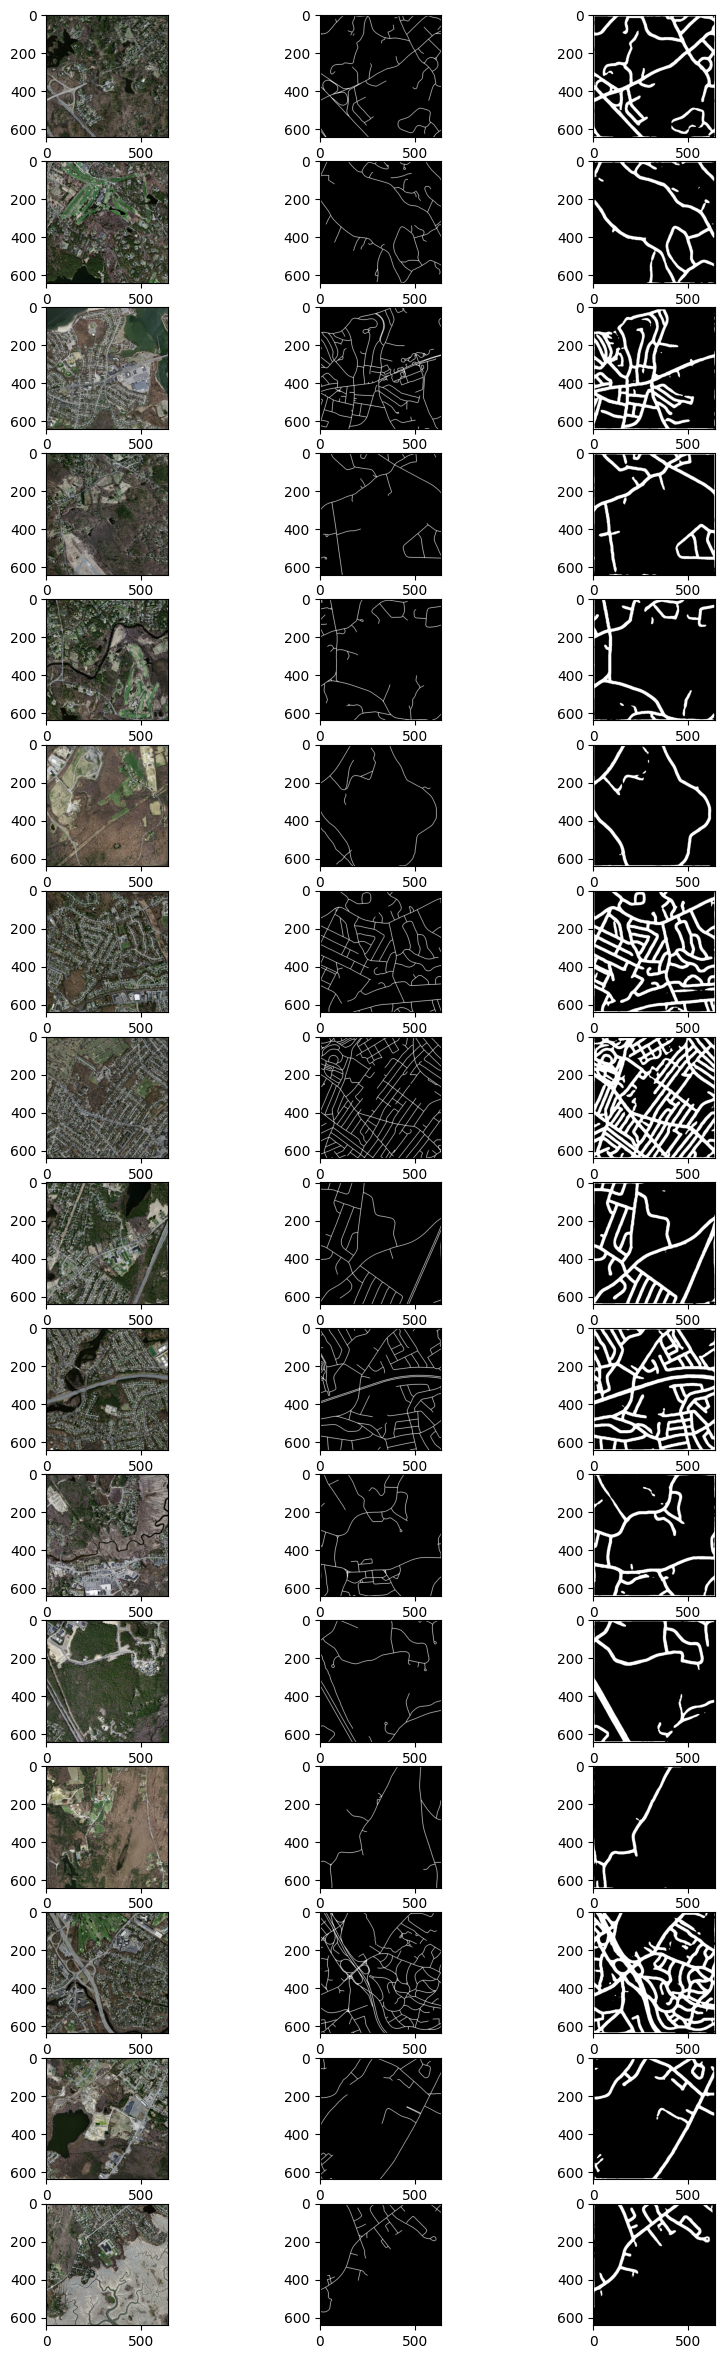

In [16]:
show_results(images, binary_masks, results)